In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import ultraplot as uplt
import xarray as xr
from shapely import from_wkt

plt.matplotlib.rcParams["image.cmap"] = "RdBu_r"

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".20"
plt.rcParams["image.cmap"] = "RdBu"


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
p = Path("/home/staniewi/dev/disp-production-data/region3-tests")
os.chdir(p)

In [4]:
box_conus = from_wkt(
    "POLYGON((-129.6935 36.6078,-51.4997 36.6078,-51.4997 53.0666,-129.6935 53.0666,-129.6935 36.6078))"
)
box_alaska = from_wkt(
    "POLYGON((-179.7236 49.2267,-120.0724 49.2267,-120.0724 75.2576,-179.7236 75.2576,-179.7236 49.2267))"
)

In [9]:
import asyncio

import zarr


class RetryingFsspecStore(zarr.storage.FsspecStore):
    max_attempts = 5
    backoff = 0.1

    async def get(
        self,
        key: str,
        prototype: zarr.core.buffer.core.BufferPrototype,
        byte_range: zarr.abc.store.ByteRequest | None = None,
    ) -> zarr.core.buffer.Buffer | None:
        for attempt in range(self.max_attempts):
            try:
                return await super().get(key, prototype, byte_range)
            except Exception:
                if attempt >= self.max_attempts - 1:
                    raise
                await asyncio.sleep(self.backoff * (2**attempt))

        raise AssertionError("Unreachable")


In [8]:
store = RetryingFsspecStore.from_url(
    "https://data.dynamical.org/noaa/gefs/analysis/latest.zarr?email=scott.stanie@utexas.edu"
)
ds = xr.open_zarr(store, decode_timedelta=True, chunks=None)
ds

<xarray.Dataset> Size: 7TB
Dimensions:                                     (time: 74756, latitude: 721,
                                                 longitude: 1440)
Coordinates:
  * latitude                                    (latitude) float64 6kB 90.0 ....
  * longitude                                   (longitude) float64 12kB -180...
    spatial_ref                                 int64 8B ...
  * time                                        (time) datetime64[ns] 598kB 2...
Data variables: (12/21)
    categorical_freezing_rain_surface           (time, latitude, longitude) float32 310GB ...
    categorical_ice_pellets_surface             (time, latitude, longitude) float32 310GB ...
    categorical_rain_surface                    (time, latitude, longitude) float32 310GB ...
    categorical_snow_surface                    (time, latitude, longitude) float32 310GB ...
    downward_long_wave_radiation_flux_surface   (time, latitude, longitude) float32 310GB ...
    downward_short_wave_radiation_flux_surface  (time, latitude, longitude) float32 310GB ...
    ...                                          ...
    temperature_2m                              (time, latitude, longitude) float32 310GB ...
    total_cloud_cover_atmosphere                (time, latitude, longitude) float32 310GB ...
    wind_u_100m                                 (time, latitude, longitude) float32 310GB ...
    wind_u_10m                                  (time, latitude, longitude) float32 310GB ...
    wind_v_100m                                 (time, latitude, longitude) float32 310GB ...
    wind_v_10m                                  (time, latitude, longitude) float32 310GB ...
Attributes:
    dataset_id:          noaa-gefs-analysis
    dataset_version:     0.1.2
    name:                NOAA GEFS analysis
    description:         Weather analysis from the Global Ensemble Forecast S...
    attribution:         NOAA NWS NCEP GEFS data processed by dynamical.org f...
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2000-01-01 00:00:00 UTC to Present
    time_resolution:     3.0 hours

In [10]:
gefs_snow = (
    ds.categorical_snow_surface.isel(longitude=slice(100, 500), latitude=slice(20, 50))
    .sel(time=slice(None, None, 100))
    .sum(dim=("latitude", "longitude"))
    .compute()
)

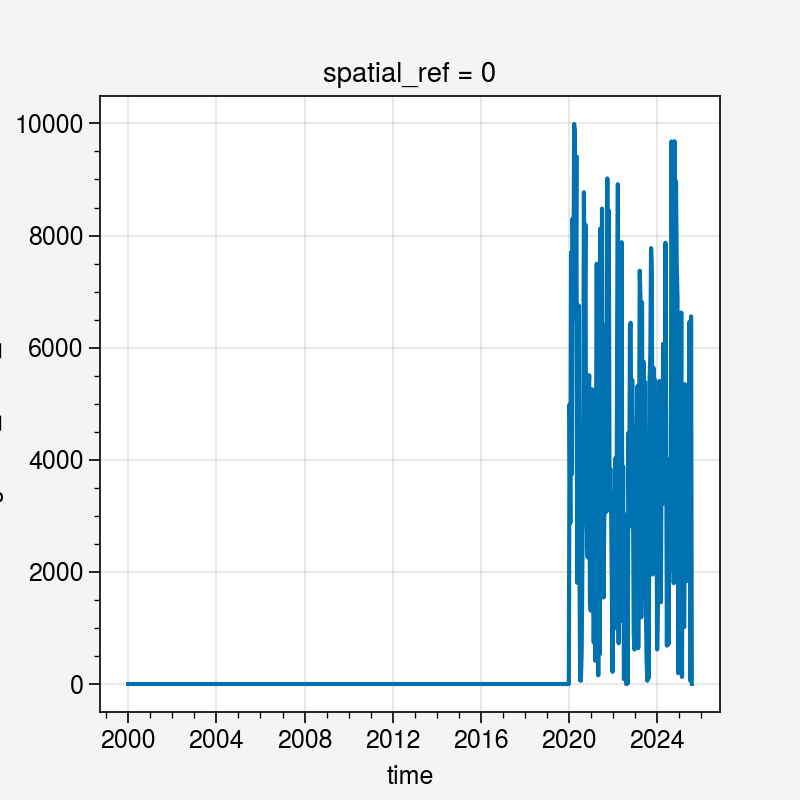

In [11]:
gefs_snow.plot()

In [12]:
ds.data_vars

Data variables:
    categorical_freezing_rain_surface           (time, latitude, longitude) float32 310GB ...
    categorical_ice_pellets_surface             (time, latitude, longitude) float32 310GB ...
    categorical_rain_surface                    (time, latitude, longitude) float32 310GB ...
    categorical_snow_surface                    (time, latitude, longitude) float32 310GB ...
    downward_long_wave_radiation_flux_surface   (time, latitude, longitude) float32 310GB ...
    downward_short_wave_radiation_flux_surface  (time, latitude, longitude) float32 310GB ...
    geopotential_height_cloud_ceiling           (time, latitude, longitude) float32 310GB ...
    maximum_temperature_2m                      (time, latitude, longitude) float32 310GB ...
    minimum_temperature_2m                      (time, latitude, longitude) float32 310GB ...
    percent_frozen_precipitation_surface        (time, latitude, longitude) float32 310GB ...
    precipitable_water_atmosphere           

In [13]:
# currently GFS is missing snow data earlier than 2020-01-01
v = (
    ds.categorical_rain_surface[::100, 300:500, 500:700]
    .sum(dim=("longitude", "latitude"))
    .compute()
)

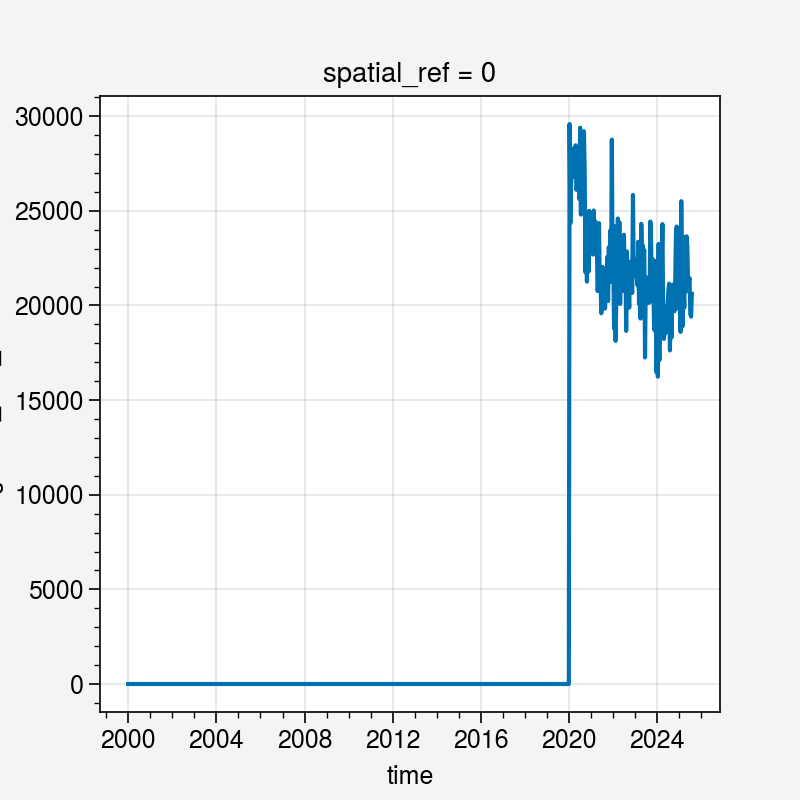

In [14]:
v.plot()

In [27]:
data_vars = [
    "categorical_snow_surface",
    "temperature_2m",
    # "minimum_temperature_2m",
    # "maximum_temperature_2m",
]
lat_slice = latitude=slice(80, 35)
lon_slice = longitude=slice(-180, -50)
time_slice = slice("2020-01-01", None)
ds_sub = ds[data_vars].sel(time=time_slice, latitude=lat_slice, longitude=lon_slice)
ds_sub

<xarray.Dataset> Size: 12GB
Dimensions:                   (time: 16316, latitude: 181, longitude: 521)
Coordinates:
  * latitude                  (latitude) float64 1kB 80.0 79.75 ... 35.25 35.0
  * longitude                 (longitude) float64 4kB -180.0 -179.8 ... -50.0
    spatial_ref               int64 8B ...
  * time                      (time) datetime64[ns] 131kB 2020-01-01 ... 2025...
Data variables:
    categorical_snow_surface  (time, latitude, longitude) float32 6GB ...
    temperature_2m            (time, latitude, longitude) float32 6GB ...
Attributes:
    dataset_id:          noaa-gefs-analysis
    dataset_version:     0.1.2
    name:                NOAA GEFS analysis
    description:         Weather analysis from the Global Ensemble Forecast S...
    attribution:         NOAA NWS NCEP GEFS data processed by dynamical.org f...
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2000-01-01 00:00:00 UTC to Present
    time_resolution:     3.0 hours

In [29]:
ds_sub.temperature_2m.shape, ds_sub.temperature_2m.size * 4 / 1e9

((16316, 181, 521), 6.154460464)

In [32]:
from zarr.codecs import BloscCodec

ntime, rows, cols = ds_sub.temperature_2m.shape

new_chunks = {"time": 1440 // 3, "latitude": rows, "longitude": cols}
new_encoding = {
    "chunks": tuple(new_chunks.values()),
    "compressors": [BloscCodec(cname="zstd", clevel=6)],
}
encoding = dict.fromkeys(ds_sub.data_vars, new_encoding)

In [33]:
%%time
ds_sub.chunk({"time": 1440 // 3, "longitude": -1, "latitude": -1}).to_zarr(
    "noaa_gefs.zarr", encoding=encoding, consolidated=False
)

CPU times: user 5min 46s, sys: 45.3 s, total: 6min 31s
Wall time: 1min 38s


In [34]:
!du -h -d1

1.6G	./noaa_gefs_alaska.zarr
1.7G	./noaa_gefs_conus.zarr
120G	./F30710-hw918
122G	./F30710-hw715
197G	./F30710-pst-request
648M	./corrections
48G	./F30710-hw918-no-winter-grace-v1
38G	./F13208-alaska-no-winter-nov-may
1.4G	./noaa_gefs.zarr
528G	.


In [35]:
ds_local = xr.open_zarr("noaa_gefs.zarr", consolidated=False)
ds_local

<xarray.Dataset> Size: 12GB
Dimensions:                   (time: 16316, latitude: 181, longitude: 521)
Coordinates:
  * time                      (time) datetime64[ns] 131kB 2020-01-01 ... 2025...
  * longitude                 (longitude) float64 4kB -180.0 -179.8 ... -50.0
    spatial_ref               int64 8B ...
  * latitude                  (latitude) float64 1kB 80.0 79.75 ... 35.25 35.0
Data variables:
    temperature_2m            (time, latitude, longitude) float32 6GB dask.array<chunksize=(480, 181, 521), meta=np.ndarray>
    categorical_snow_surface  (time, latitude, longitude) float32 6GB dask.array<chunksize=(480, 181, 521), meta=np.ndarray>
Attributes:
    dataset_id:          noaa-gefs-analysis
    dataset_version:     0.1.2
    name:                NOAA GEFS analysis
    description:         Weather analysis from the Global Ensemble Forecast S...
    attribution:         NOAA NWS NCEP GEFS data processed by dynamical.org f...
    spatial_domain:      Global
    spatial_resolution:  0.25 degrees (~20km)
    time_domain:         2000-01-01 00:00:00 UTC to Present
    time_resolution:     3.0 hours

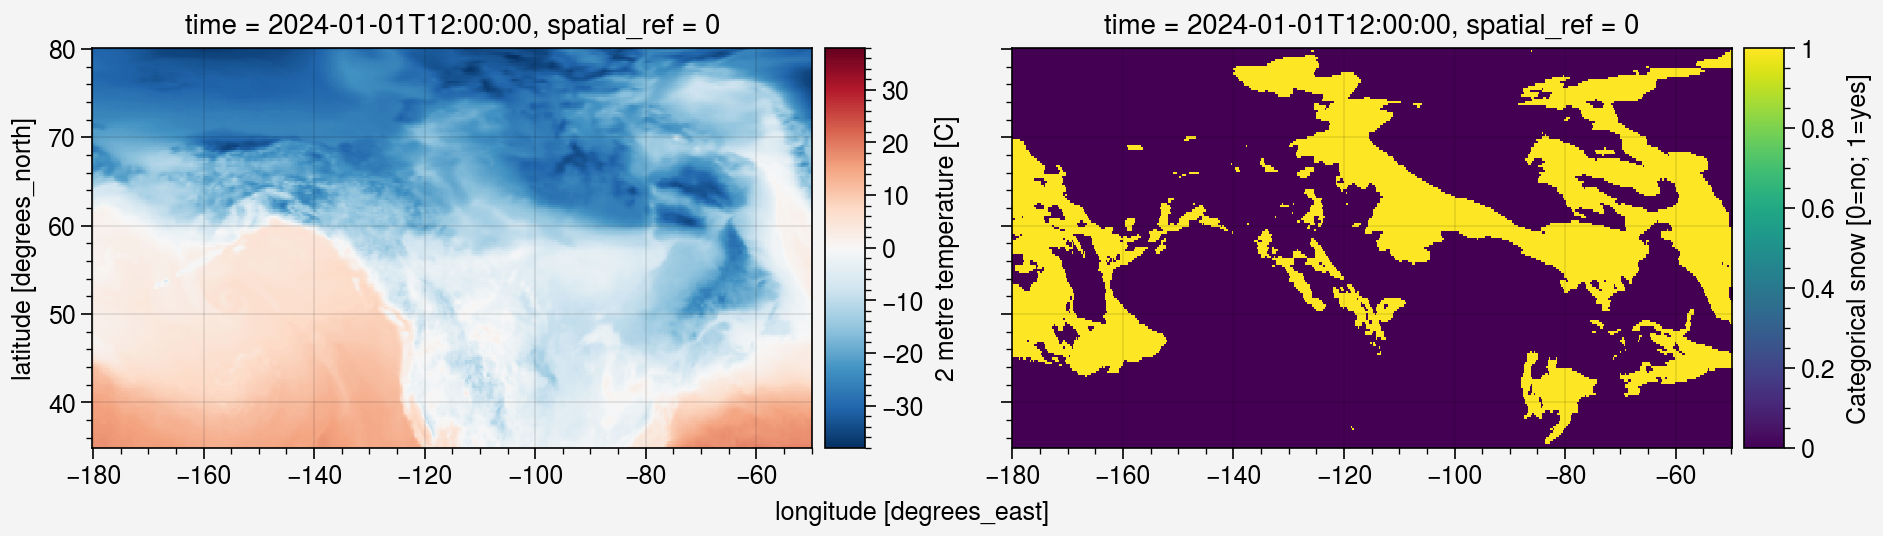

In [36]:
fig, axes = uplt.subplots(ncols=2, refwidth=3.6, refheight=2)

d = ds_local.sel(time="2024-01-01 12:00:00")

d.temperature_2m.plot.imshow(ax=axes[0])
d.categorical_snow_surface.plot.imshow(ax=axes[1])